### Pre-trained Inception V1

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

In [3]:
checkpoints_dir = './tmp/checkpoints'

In [4]:
slim = tf.contrib.slim

In [5]:
image_size = inception.inception_v1.default_image_size
image_size

224

In [6]:
def create_readable_names_for_imagenet_labels():
    synset_list = [s.strip() for s in open('./tmp/imagenet/imagenet_lsvrc_2015_synsets.txt').readlines()]
    num_synsets_in_ilsvrc = len(synset_list)
    assert num_synsets_in_ilsvrc == 1000

    synset_to_human_list = open('./tmp/imagenet/imagenet_metadata.txt').readlines()
    num_synsets_in_all_imagenet = len(synset_to_human_list)
    assert num_synsets_in_all_imagenet == 21842

    synset_to_human = {}
    for s in synset_to_human_list:
        parts = s.strip().split('\t')
        assert len(parts) == 2
        synset = parts[0]
        human = parts[1]
        synset_to_human[synset] = human

    label_index = 1
    labels_to_names = {0: 'background'}
    for synset in synset_list:
        name = synset_to_human[synset]
        labels_to_names[label_index] = name
        label_index += 1

    return labels_to_names

In [7]:
names = create_readable_names_for_imagenet_labels()

In [12]:
%%time
with open("./img/2.jpg", "rb") as imageFile:
    f = imageFile.read()
    b = bytes(f)
image = tf.image.decode_jpeg(b, channels=3)

processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size,
                                                           is_training=False)
processed_images  = tf.expand_dims(processed_image, 0)

with slim.arg_scope(inception.inception_v1_arg_scope()):
    logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
    slim.get_model_variables('InceptionV1'))

with tf.Session() as sess:
    init_fn(sess)
    np_image, probabilities = sess.run([image, probabilities])
    probabilities = probabilities[0, 0:]
    sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]

Wall time: 6.97 s


0.99 => school bus
0.00 => minibus
0.00 => trolleybus, trolley coach, trackless trolley
0.00 => cab, hack, taxi, taxicab
0.00 => passenger car, coach, carriage


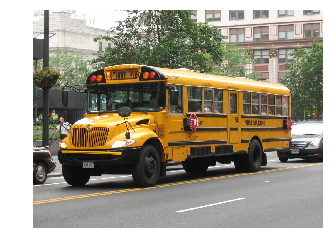

In [13]:
plt.imshow(np_image)
plt.axis('off')

for i in range(5):
    index = sorted_inds[i]
    print('%0.2f => %s' % (probabilities[index], names[index]))